In [1]:
import requests
import json

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
%matplotlib inline

from spineq.utils import coverage
from spineq.plotting import plot_coverage_grid

In [2]:
query = "http://uoweb3.ncl.ac.uk/api/v1.1/sensors/json/?theme=Air+Quality&bbox_p1_x=-1.988472&bbox_p1_y=54.784364&bbox_p2_x=-1.224922&bbox_p2_y=55.190148"
response = requests.get(query)
response

<Response [200]>

In [3]:
jresponse = json.loads(response.content)
sensors = jresponse["sensors"]
sensors

[{'Sensor Height Above Ground': 2.0,
  'Location (WKT)': 'POINT (-1.623452 54.928095)',
  'Raw ID': '79549',
  'Broker Name': 'TOPAS AQ',
  'Sensor Centroid Latitude': 54.928095,
  'Sensor Centroid Longitude': -1.623452,
  'Third Party': False,
  'Sensor Name': 'PER_TOPAS_TNT1723_TOPAS',
  'Ground Height Above Sea Level': 13.0399999619},
 {'Sensor Height Above Ground': 2.0,
  'Location (WKT)': 'POINT (-1.901984 54.986616)',
  'Raw ID': '79550',
  'Broker Name': 'TOPAS AQ',
  'Sensor Centroid Latitude': 54.986616,
  'Sensor Centroid Longitude': -1.901984,
  'Third Party': False,
  'Sensor Name': 'PER_TOPAS_TNT1724_TOPAS',
  'Ground Height Above Sea Level': 113.6299972534},
 {'Sensor Height Above Ground': 2.0,
  'Location (WKT)': 'POINT (-1.440904 54.989386)',
  'Raw ID': '79551',
  'Broker Name': 'TOPAS AQ',
  'Sensor Centroid Latitude': 54.989386,
  'Sensor Centroid Longitude': -1.440904,
  'Third Party': False,
  'Sensor Name': 'PER_TOPAS_TNT1725_TOPAS',
  'Ground Height Above Sea Lev

In [4]:
df = pd.DataFrame(sensors)
df.head()

Sensor Height Above Ground               Location (WKT) Raw ID Broker Name  \
0                         2.0  POINT (-1.623452 54.928095)  79549    TOPAS AQ   
1                         2.0  POINT (-1.901984 54.986616)  79550    TOPAS AQ   
2                         2.0  POINT (-1.440904 54.989386)  79551    TOPAS AQ   
3                         2.0  POINT (-1.625729 54.973816)  79552    TOPAS AQ   
4                         2.0  POINT (-1.457618 54.966725)  79553    TOPAS AQ   

   Sensor Centroid Latitude  Sensor Centroid Longitude  Third Party  \
0                 54.928095                  -1.623452        False   
1                 54.986616                  -1.901984        False   
2                 54.989386                  -1.440904        False   
3                 54.973816                  -1.625729        False   
4                 54.966725                  -1.457618        False   

               Sensor Name  Ground Height Above Sea Level  
0  PER_TOPAS_TNT1723_TOPAS                      13.040000  
1  PER_TOPAS_TNT1724_TOPAS                     113.629997  
2  PER_TOPAS_TNT1725_TOPAS                      10.430000  
3  PER_TOPAS_TNT1726_TOPAS                      64.500000  
4  PER_TOPAS_TNT1727_TOPAS                      24.240000

In [5]:
gdf = gpd.GeoDataFrame(df,
                       geometry=gpd.points_from_xy(df["Sensor Centroid Longitude"],
                                                   df["Sensor Centroid Latitude"]),
                       crs={'init': 'epsg:4326'})

# Convert to British National Grid CRS (same as ONS data)
gdf = gdf.to_crs({'init': 'epsg:27700'})

# remove duplicate column - available as "geometry"
gdf.drop("Location (WKT)", inplace=True, axis=1)

gdf.head()

/Users/jroberts/opt/anaconda3/envs/spatial-inequality/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Sensor Height Above Ground Raw ID Broker Name  Sensor Centroid Latitude  \
0                         2.0  79549    TOPAS AQ                 54.928095   
1                         2.0  79550    TOPAS AQ                 54.986616   
2                         2.0  79551    TOPAS AQ                 54.989386   
3                         2.0  79552    TOPAS AQ                 54.973816   
4                         2.0  79553    TOPAS AQ                 54.966725   

   Sensor Centroid Longitude  Third Party              Sensor Name  \
0                  -1.623452        False  PER_TOPAS_TNT1723_TOPAS   
1                  -1.901984        False  PER_TOPAS_TNT1724_TOPAS   
2                  -1.440904        False  PER_TOPAS_TNT1725_TOPAS   
3                  -1.625729        False  PER_TOPAS_TNT1726_TOPAS   
4                  -1.457618        False  PER_TOPAS_TNT1727_TOPAS   

   Ground Height Above Sea Level                       geometry  
0                      13.040000  POINT (424228.968 559332.668)  
1                     113.629997  POINT (406370.267 565784.538)  
2                      10.430000  POINT (435872.917 566231.248)  
3                      64.500000  POINT (424055.859 564419.747)  
4                      24.240000  POINT (434822.990 563701.111)

In [6]:
# Get sensors in Newcastle upon tyne local authority only

# Get Newcastle upon tyne LA geometry
la = gpd.read_file("../data/raw/la")
tyne_la = la[la["lad18nm"] == "Newcastle upon Tyne"].iloc[0]


gdf = gdf[gdf.intersects(tyne_la["geometry"])]

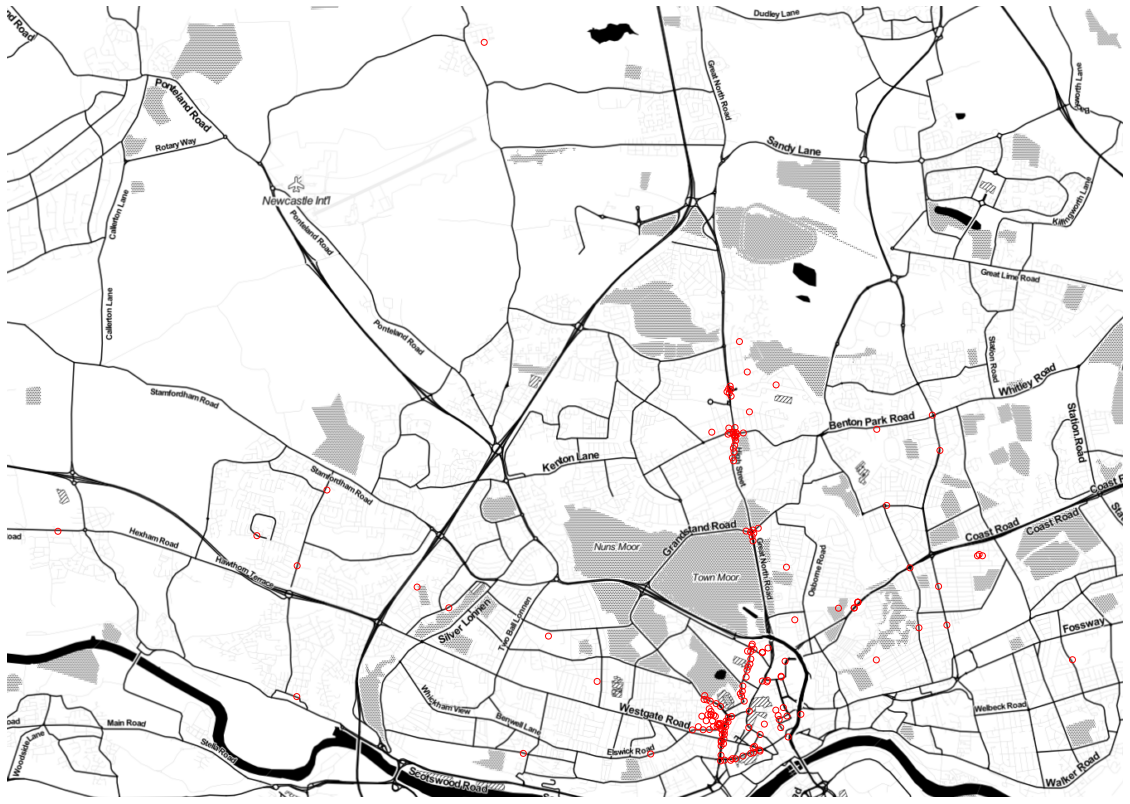

In [7]:
ax = gdf.plot(figsize=(20,20), facecolor='none', edgecolor='red')
ctx.add_basemap(ax,
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=gdf.crs)
ax.set_axis_off()
# url="https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}.png"


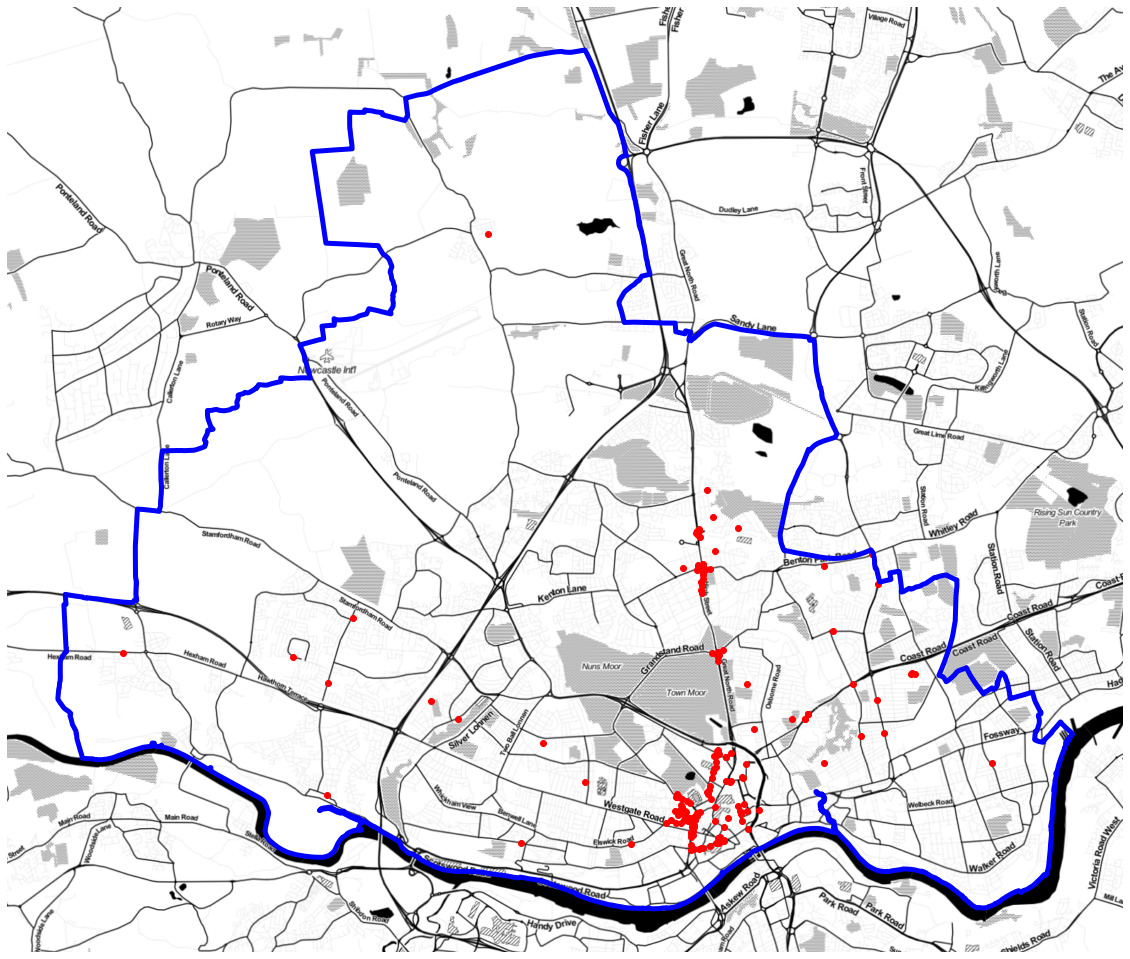

In [8]:
ax = plt.figure(figsize=(20,20)).gca()
x,y = tyne_la["geometry"].exterior.xy
ax.plot(x,y, 'blue', linewidth=5)
gdf.plot(ax=ax, edgecolor='red', facecolor='red')
ctx.add_basemap(ax,
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=gdf.crs)
ax.set_axis_off()


In [9]:
df[df[["Sensor Centroid Latitude", "Sensor Centroid Latitude"]].duplicated(keep=False)].sort_values(by="Sensor Centroid Latitude")

Sensor Height Above Ground                              Location (WKT)  \
51                          2.0                 POINT (-1.594598 54.987092)   
153                         2.0                 POINT (-1.594598 54.987092)   
155                         2.0                 POINT (-1.594598 54.987092)   
15                          2.0  POINT (-1.56980037689209 54.9925237389721)   
16                          2.0  POINT (-1.56877040863037 54.9925237389721)   
5                           2.0                 POINT (-1.619851 55.007007)   
217                         2.0                 POINT (-1.619841 55.007007)   

    Raw ID               Broker Name  Sensor Centroid Latitude  \
51    1725               aq_mesh_api                 54.987092   
153   1609  Emote Air Quality Sensor                 54.987092   
155   1611  Emote Air Quality Sensor                 54.987092   
15    1616      Citizen Science Kits                 54.992524   
16    1618      Citizen Science Kits                 54.992524   
5    79554                  TOPAS AQ                 55.007007   
217  79268  Emote Air Quality Sensor                 55.007007   

     Sensor Centroid Longitude  Third Party  \
51                   -1.594598        False   
153                  -1.594598        False   
155                  -1.594598        False   
15                   -1.569800        False   
16                   -1.568770        False   
5                    -1.619851        False   
217                  -1.619841        False   

                                           Sensor Name  \
51                               PER_AIRMON_MONITOR915   
153                                     PER_EMOTE_1171   
155                                     PER_EMOTE_1173   
15   PER_CITIZEN_CROWD_SOURCED_NEWCASTLE_UNIVERSITY...   
16   PER_CITIZEN_CROWD_SOURCED_NEWCASTLE_UNIVERSITY...   
5                              PER_TOPAS_TNT1728_TOPAS   
217                                     PER_EMOTE_2797   

     Ground Height Above Sea Level                   geometry  
51                       41.509998  POINT (-1.59460 54.98709)  
153                      41.509998  POINT (-1.59460 54.98709)  
155                      41.509998  POINT (-1.59460 54.98709)  
15                       41.599998  POINT (-1.56980 54.99252)  
16                       40.580002  POINT (-1.56877 54.99252)  
5                        62.669998  POINT (-1.61985 55.00701)  
217                      62.669998  POINT (-1.61984 55.00701)

In [10]:
# Get sensors in Newcastle upon tyne local authority only

# Get Newcastle upon tyne LA geometry
oa = gpd.read_file("../data/processed/tyne_oa")
oa.head()

oa11cd    lad11cd           X           Y  Population  \
0  E00042042  E08000021  421259.393  564639.754         310   
1  E00042043  E08000021  420448.616  564819.213         304   
2  E00042044  E08000021  420509.207  564622.209         246   
3  E00042045  E08000021  421551.722  564088.460         201   
4  E00042046  E08000021  422116.597  563648.529         424   

                                            geometry  
0  POLYGON ((421301.772 564928.429, 421301.755 56...  
1  POLYGON ((420572.364 564892.821, 420572.312 56...  
2  POLYGON ((420492.559 564780.806, 420492.590 56...  
3  POLYGON ((421543.715 563955.116, 421542.251 56...  
4  POLYGON ((422650.214 563568.422, 422650.020 56...

In [11]:
sensors_with_oa = gpd.sjoin(gdf, oa, how="left")
oa_sensor_counts = sensors_with_oa.groupby("oa11cd")["Raw ID"].count().sort_values(ascending=False)
oa_sensor_counts

oa11cd
E00042825    22
E00042580    19
E00042735    10
E00042820     9
E00042822     7
             ..
E00175587     1
E00042537     1
E00042443     1
E00042441     1
E00042059     1
Name: Raw ID, Length: 62, dtype: int64

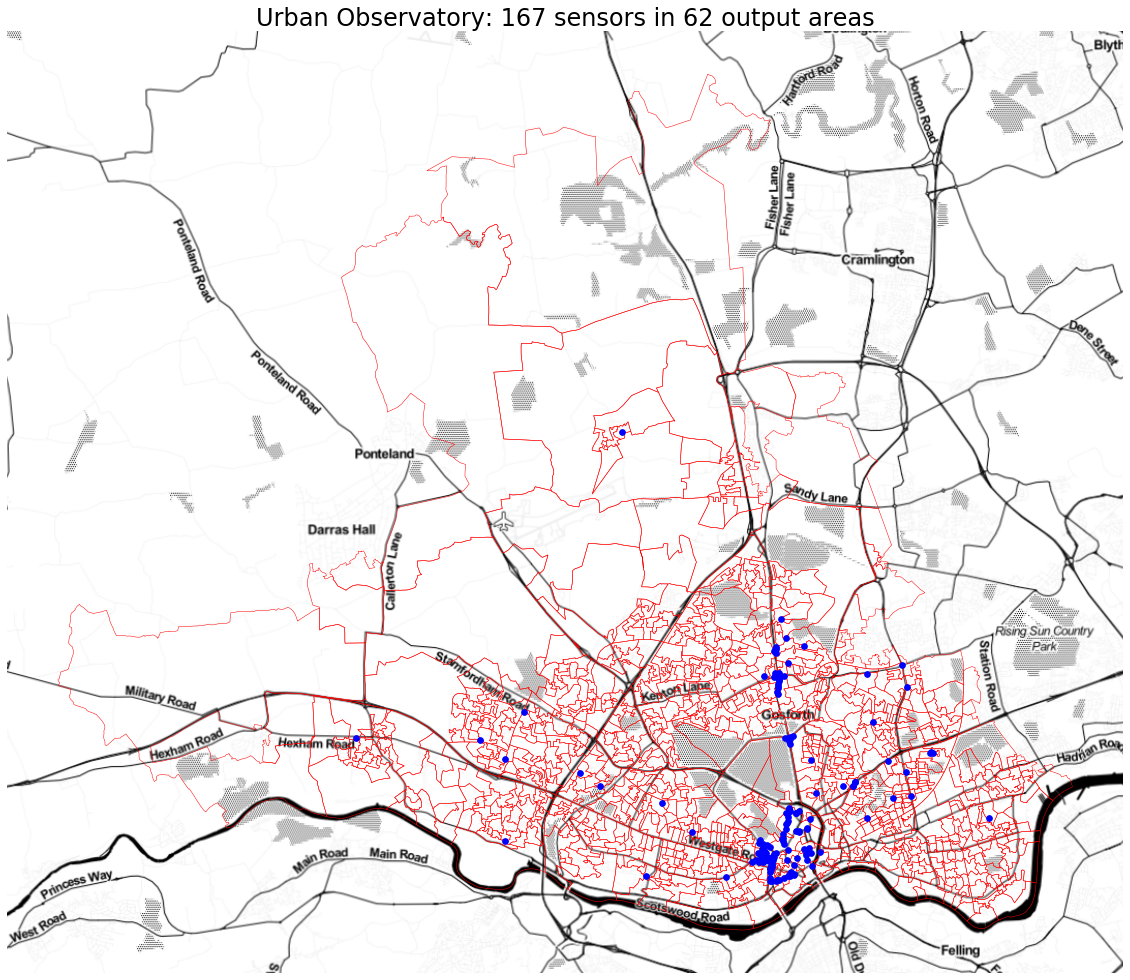

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(20,20))

oa.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)

ctx.add_basemap(ax,
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=oa.crs)

gdf.plot(ax=ax, edgecolor='blue', facecolor='blue', markersize=32, figsize=(20,20))

plt.title("Urban Observatory: {} sensors in {} output areas".format(len(gdf), len(oa_sensor_counts)),
          fontsize=24)

ax.set_axis_off()

#plt.tight_layout()
#plt.savefig("../data/img/uo_sensors.png", dpi=300)

(<Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe2b92cf630>)

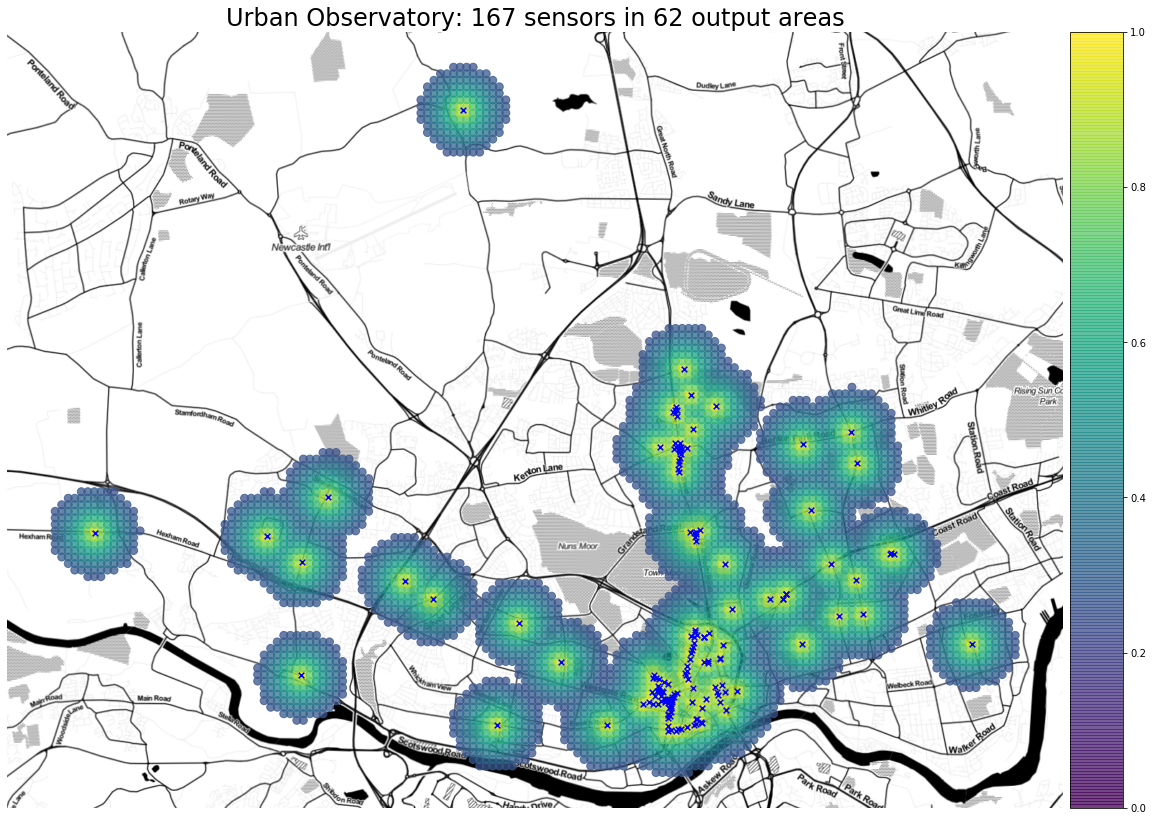

In [13]:
sensors = np.array([gdf["geometry"].x, gdf["geometry"].y]).T
bounds = oa["geometry"].bounds
xlim = (bounds["minx"].min(), bounds["maxx"].max())
ylim =(bounds["miny"].min(), bounds["maxy"].max())
title = "Urban Observatory: {} sensors in {} output areas".format(len(gdf), 
                                                                    len(oa_sensor_counts))
save_path = "../data/img/uo_coverage.png"
plot_coverage_grid(sensors, xlim, ylim, title=title, save_path=save_path)